# text extraction with tesseract

In [1]:
import cv2
import json
import numpy as np
from PIL import Image
import pytesseract
import layoutparser as lp
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

In [2]:
# Configure Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
custom_config = r'--psm 1'

In [3]:
def visualize_layout_detection(image, layout, table_threshold=0.3, figure_threshold=0.8, show_plot=True):
    """
    Visualize only tables and figures if any are detected
    """
    # First check if there are any valid detections
    has_detections = False
    for block in layout:
        block_type = get_block_type(block)
        score = float(block.score) if hasattr(block, 'score') else 0.8
        
        if ((block_type == 'Table' and score >= table_threshold) or 
            (block_type == 'Figure' and score >= figure_threshold)):
            has_detections = True
            break
    
    if not has_detections:
        print("No tables or figures detected on this page.")
        return None
        
    viz_image = image.copy()
    draw = ImageDraw.Draw(viz_image)
    
    # Only visualize tables and figures
    for block in layout:
        block_type = get_block_type(block)
        score = float(block.score) if hasattr(block, 'score') else 0.8
        
        if block_type == 'Table' and score >= table_threshold:
            color = 'red'
            label = 'Table'
        elif block_type == 'Figure' and score >= figure_threshold:
            color = 'green'
            label = 'Figure'
        else:
            continue
            
        coords = [int(c) for c in block.coordinates]
        draw.rectangle(coords, outline=color, width=2)
        draw.text((coords[0], coords[1]-20), f"{label} ({score:.2f})", fill=color)
    
    if show_plot:
        plt.figure(figsize=(15, 10))
        plt.imshow(viz_image)
        plt.axis('off')
        plt.title('Detected Tables (Red) and Figures (Green)')
        plt.show()
    
    return viz_image

In [4]:
def visualize_masked_regions(image, mask, show_plot=True):
    """Visualize masked regions for tables and figures"""
    # Check if there are any masked regions
    if not np.any(mask):
        print("No regions to mask on this page.")
        return None
        
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image
    
    viz_image = img_array.copy()
    if len(viz_image.shape) == 2:
        viz_image = np.stack([viz_image] * 3, axis=-1)
    
    # Add semi-transparent overlay for masked regions
    overlay = viz_image.copy()
    overlay[mask] = [255, 0, 0]  # Red for masked areas
    viz_image = cv2.addWeighted(overlay, 0.3, viz_image, 0.7, 0)
    
    if show_plot:
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img_array)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(viz_image)
        plt.title('Masked Tables and Figures')
        plt.axis('off')
        plt.show()
    
    return viz_image

In [5]:
def visualize_text_blocks(image, text_blocks, show_plot=True):
    """
    Visualize detected text blocks
    
    Args:
        image: Original PIL Image
        text_blocks: List of detected text blocks with positions
        show_plot: Whether to display the plot
    """
    viz_image = image.copy()
    draw = ImageDraw.Draw(viz_image)
    
    # Draw each text block
    for block in text_blocks:
        y_pos = block['y_position']
        text = block['content'][:50] + '...' if len(block['content']) > 50 else block['content']
        
        # Draw a line at the text block position
        draw.line([(0, y_pos), (image.size[0], y_pos)], fill='blue', width=1)
        draw.text((10, y_pos), text, fill='blue')
    
    if show_plot:
        plt.figure(figsize=(15, 10))
        plt.imshow(viz_image)
        plt.axis('off')
        plt.title('Detected Text Blocks')
        plt.show()
    
    return viz_image

In [6]:
def visualize_content_order(image, content_blocks, show_plot=True):
    """
    Visualize the order of all content blocks
    
    Args:
        image: Original PIL Image
        content_blocks: List of all content blocks with positions
        show_plot: Whether to display the plot
    """
    viz_image = image.copy()
    draw = ImageDraw.Draw(viz_image)
    
    # Color mapping for different block types
    colors = {
        'text': 'blue',
        'table': 'red',
        'figure': 'green'
    }
    
    # Draw numbered markers for each block in order
    for idx, block in enumerate(content_blocks):
        y_pos = block['y_position']
        block_type = block['type'].lower()
        color = colors.get(block_type, 'gray')
        
        # Draw circle with number
        circle_x = 50
        circle_y = y_pos
        circle_radius = 15
        draw.ellipse(
            [
                circle_x - circle_radius, 
                circle_y - circle_radius,
                circle_x + circle_radius, 
                circle_y + circle_radius
            ],
            outline=color,
            width=2
        )
        # Add number
        draw.text(
            (circle_x - 5, circle_y - 7),
            str(idx + 1),
            fill=color
        )
        
        # Draw line across page
        draw.line(
            [(circle_x + circle_radius, circle_y), (image.size[0] - 50, circle_y)],
            fill=color,
            width=1
        )
        
        # Add block type label
        draw.text(
            (circle_x + circle_radius + 10, circle_y - 7),
            f"{block_type}",
            fill=color
        )
    
    if show_plot:
        plt.figure(figsize=(15, 10))
        plt.imshow(viz_image)
        plt.axis('off')
        plt.title('Content Blocks Order')
        plt.show()
    
    return viz_image

In [7]:
def create_mask_for_regions(image_size, regions):
    """Create a boolean mask for regions to ignore"""
    mask = np.zeros(image_size[::-1], dtype=bool)
    
    for coords in regions:
        x1, y1, x2, y2 = [int(c) for c in coords]
        # Add some padding around the region
        x1 = max(0, x1 - 5)
        y1 = max(0, y1 - 5)
        x2 = min(image_size[0], x2 + 5)
        y2 = min(image_size[1], y2 + 5)
        mask[y1:y2, x1:x2] = True
        
    return mask

In [8]:
def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IoU) between two bounding boxes
    
    Args:
        box1: First bounding box coordinates [x1, y1, x2, y2]
        box2: Second bounding box coordinates [x1, y1, x2, y2]
        
    Returns:
        float: IoU score between 0 and 1
    """
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i <= x1_i or y2_i <= y1_i:
        return 0.0
    
    intersection = (x2_i - x1_i) * (y2_i - y1_i)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

In [9]:
def get_block_type(block):
    """Helper function to safely get block type"""
    if hasattr(block, 'type'):
        return block.type
    
    if hasattr(block, 'label'):
        if isinstance(block.label, str):
            return block.label
        if isinstance(block.label, (int, float)):
            type_mapping = {
                0: 'Text',
                1: 'Title',
                2: 'List',
                3: 'Table',
                4: 'Figure'
            }
            return type_mapping.get(int(block.label), 'Unknown')
    
    return 'Unknown'

In [10]:
def process_media_block(block, image, output_folder, page_num, media_type):
    """Process a table or figure block"""
    coords = [int(c) for c in block.coordinates]
    
    # Ensure coordinates are within bounds
    coords = [
        max(0, coords[0]),
        max(0, coords[1]),
        min(image.size[0], coords[2]),
        min(image.size[1], coords[3])
    ]
    
    if coords[2] <= coords[0] or coords[3] <= coords[1]:
        return None
        
    # Save media file
    folder_name = f"{media_type}s"
    save_path = output_folder / folder_name
    save_path.mkdir(parents=True, exist_ok=True)
    filename = f"{media_type}_{page_num}.png"
    full_path = save_path / filename
    
    cropped = image.crop(coords)
    cropped.save(full_path)
    
    return {
        'block': {
            'type': media_type,
            'path': str(full_path),
            'y_position': coords[1],
            'confidence': float(block.score) if hasattr(block, 'score') else 0.8
        },
        'coords': coords,
        'file_path': str(full_path)
    }

In [11]:
def process_text(image, confidence_threshold=30):
    """Process text using Tesseract OCR"""
    text_data = pytesseract.image_to_data(
        image,
        config=custom_config,
        output_type=pytesseract.Output.DICT
    )
    
    text_blocks = []
    current_block = []
    current_block_y = None
    last_block_num = -1
    
    for i in range(len(text_data['text'])):
        if text_data['conf'][i] > confidence_threshold:
            block_num = text_data['block_num'][i]
            
            if block_num != last_block_num:
                if current_block:
                    text_content = ' '.join(current_block).strip()
                    if text_content:
                        text_blocks.append({
                            'type': 'text',
                            'content': text_content,
                            'y_position': current_block_y
                        })
                current_block = []
                current_block_y = text_data['top'][i]
            
            current_block.append(text_data['text'][i])
            last_block_num = block_num
    
    if current_block:
        text_content = ' '.join(current_block).strip()
        if text_content:
            text_blocks.append({
                'type': 'text',
                'content': text_content,
                'y_position': current_block_y
            })
    
    return text_blocks

In [12]:
def process_page(image_path, layout_model, output_folder, page_num, table_threshold=0.1, figure_threshold=0.9):
    """Process a single page focusing only on tables and figures, prioritizing tables"""
    print(f"\nProcessing page {page_num}")
    
    try:
        # Load and check image
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        img_array = np.array(image)
        
        # Initialize result structure
        page_result = {
            'page_num': page_num,
            'figures': [],
            'tables': [],
            'text': ''
        }
        
        # Detect layout
        print("Detecting tables and figures...")
        layout = layout_model.detect(image)
        
        # Collect detections, separating tables and figures
        table_detections = []
        figure_detections = []
        
        for block in layout:
            block_type = get_block_type(block)
            score = float(block.score) if hasattr(block, 'score') else 0.8
            
            if block_type == 'Table' and score >= table_threshold:
                coords = [int(c) for c in block.coordinates]
                table_detections.append({
                    'type': block_type,
                    'score': score,
                    'coords': coords,
                    'block': block
                })
            elif block_type == 'Figure' and score >= figure_threshold:
                coords = [int(c) for c in block.coordinates]
                figure_detections.append({
                    'type': block_type,
                    'score': score,
                    'coords': coords,
                    'block': block
                })
        
        # Sort each list by confidence
        table_detections.sort(key=lambda x: x['score'], reverse=True)
        figure_detections.sort(key=lambda x: x['score'], reverse=True)
        
        # Only visualize if we have any detections
        if table_detections or figure_detections:
            visualize_layout_detection(image, layout, table_threshold, figure_threshold)
        
        # Process tables first
        processed_regions = []
        regions_to_mask = []
        
        # Process tables
        for detection in table_detections:
            is_overlapping = False
            for processed in processed_regions:
                if compute_iou(detection['coords'], processed) > 0.3:
                    is_overlapping = True
                    break
            
            if not is_overlapping:
                try:
                    media_result = process_media_block(
                        detection['block'], 
                        image, 
                        output_folder, 
                        page_num, 
                        'table'
                    )
                    if media_result:
                        processed_regions.append(detection['coords'])
                        regions_to_mask.append(media_result['coords'])
                        page_result['tables'].append(media_result)
                except Exception as e:
                    print(f"Error processing table: {str(e)}")
                    continue
        
        # Process figures (only if they don't overlap with already processed tables)
        for detection in figure_detections:
            is_overlapping = False
            for processed in processed_regions:
                if compute_iou(detection['coords'], processed) > 0.3:
                    is_overlapping = True
                    break
            
            if not is_overlapping:
                try:
                    media_result = process_media_block(
                        detection['block'], 
                        image, 
                        output_folder, 
                        page_num, 
                        'figure'
                    )
                    if media_result:
                        processed_regions.append(detection['coords'])
                        regions_to_mask.append(media_result['coords'])
                        page_result['figures'].append(media_result)
                except Exception as e:
                    print(f"Error processing figure: {str(e)}")
                    continue
        
        # Create and visualize mask if we have regions to mask
        if regions_to_mask:
            mask = create_mask_for_regions(image.size, regions_to_mask)
            visualize_masked_regions(image, mask)
            
            # Extract text from non-masked regions
            masked_image = img_array.copy()
            masked_image[mask] = 255  # White out masked regions
            masked_image = Image.fromarray(masked_image)
        else:
            # If no regions to mask, use original image for text extraction
            masked_image = image
        
        # Extract full page text
        page_result['text'] = pytesseract.image_to_string(
            masked_image,
            config='--psm 1'
        )
        
        if regions_to_mask:
            print(f"Found {len(page_result['tables'])} tables and {len(page_result['figures'])} figures")
        else:
            print("No tables or figures found on this page")
            
        return page_result
        
    except Exception as e:
        print(f"Error processing page {page_num}: {str(e)}")
        return None

In [13]:
def process_article(article_folder, table_threshold=0.1, figure_threshold=0.9):
    """Process entire article"""
    article_name = article_folder.name
    output_folder = article_folder.parent / f"{article_name}_processed"
    output_folder.mkdir(parents=True, exist_ok=True)
    
    # Initialize Layout Parser model
    layout_model = lp.Detectron2LayoutModel(
        'lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
        extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", min(table_threshold, figure_threshold)],
        label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
    )
    
    result = {
        'article_name': article_name,
        'pages': []
    }
    
    # Get all pages and sort them numerically
    pages = list(article_folder.glob("*.png"))
    pages.sort(key=lambda x: int(x.stem.split('_')[1]))  # Extract number after 'page_' and sort numerically
    
    for page_num, page_path in enumerate(pages, 1):
        print(f"Processing page {page_num}/{len(pages)}")
        page_result = process_page(
            page_path, 
            layout_model, 
            output_folder, 
            page_num,
            table_threshold,
            figure_threshold
        )
        if page_result:
            result['pages'].append(page_result)
    
    # Save results
    with open(output_folder / 'result.json', 'w', encoding='utf-8') as f:
        json.dump(result, f, ensure_ascii=False, indent=2)
    
    return result

c:\Users\thinkpad\Documents\GitHub\Textra_ai_research_vc\venv\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.l

Processing page 1/16

Processing page 1
Detecting tables and figures...


c:\Users\thinkpad\Documents\GitHub\Textra_ai_research_vc\venv\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


No tables or figures found on this page
Processing page 2/16

Processing page 2
Detecting tables and figures...


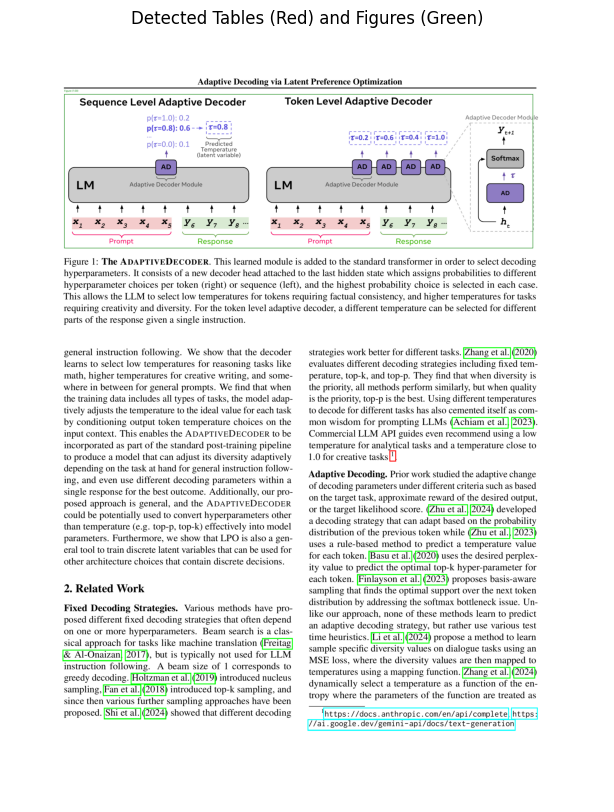

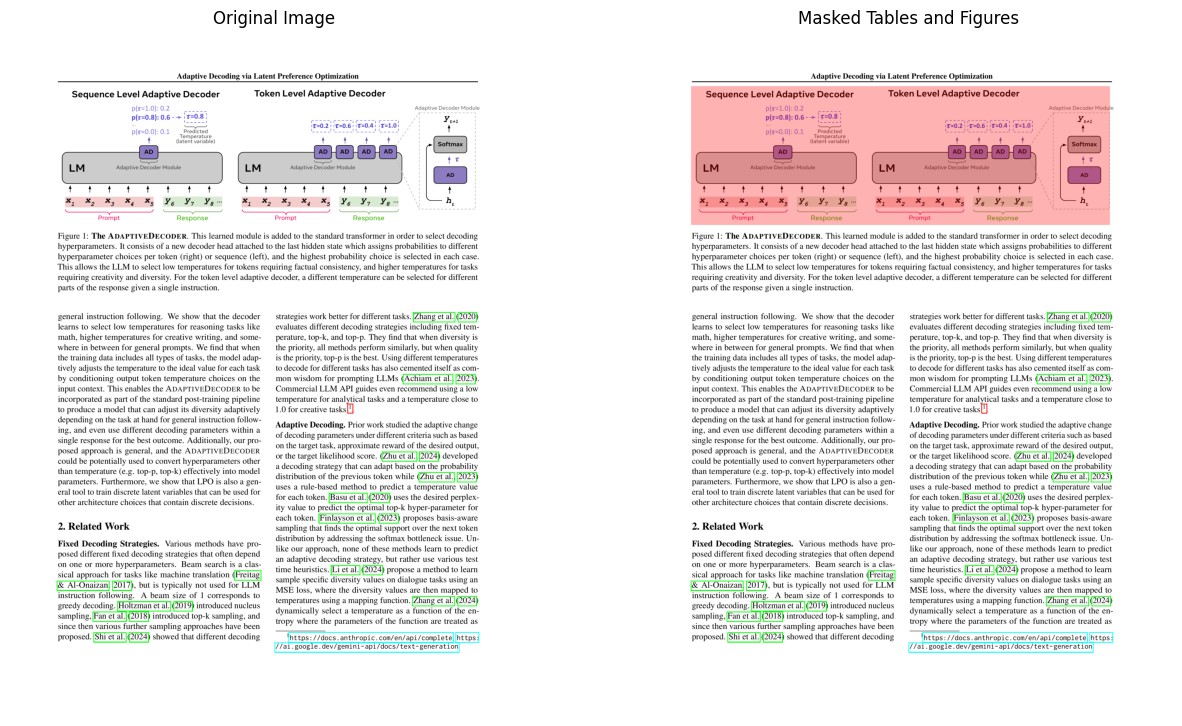

Found 0 tables and 1 figures
Processing page 3/16

Processing page 3
Detecting tables and figures...


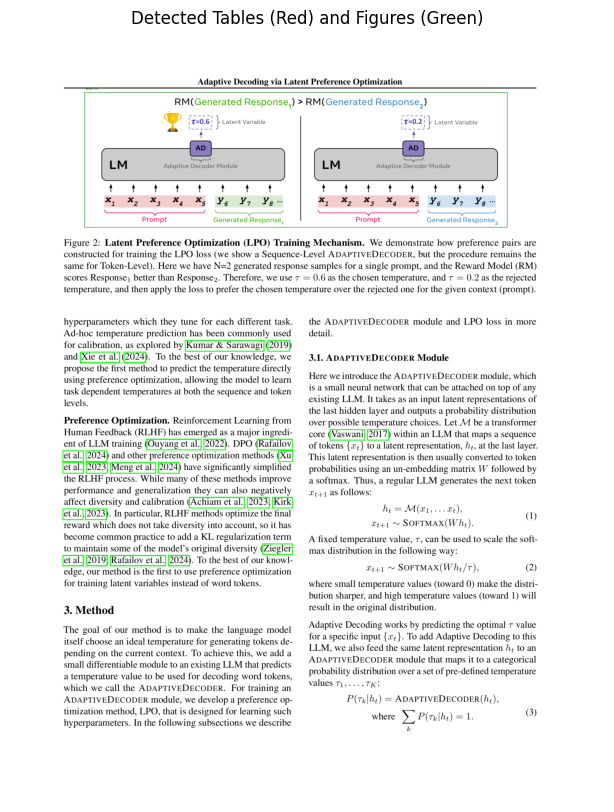

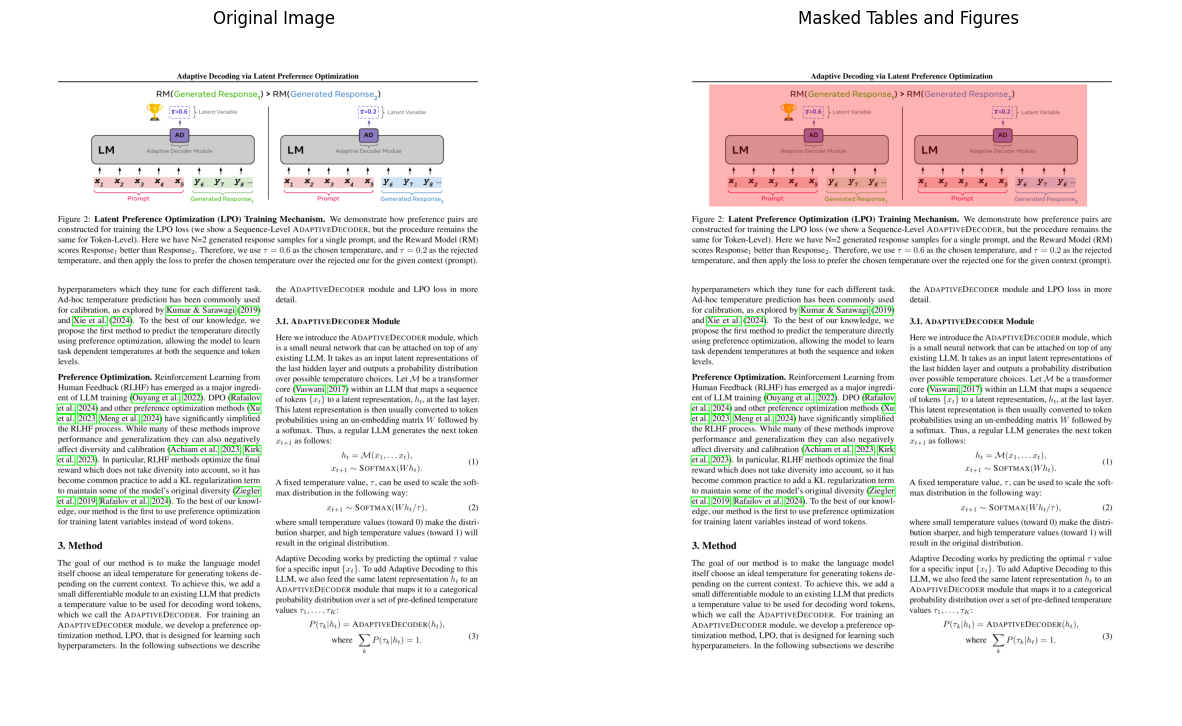

Found 0 tables and 1 figures
Processing page 4/16

Processing page 4
Detecting tables and figures...
No tables or figures found on this page
Processing page 5/16

Processing page 5
Detecting tables and figures...


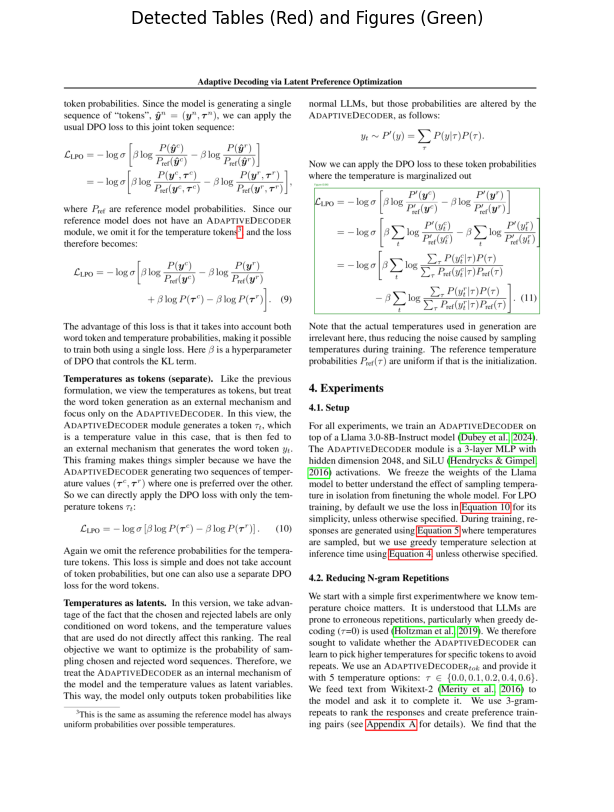

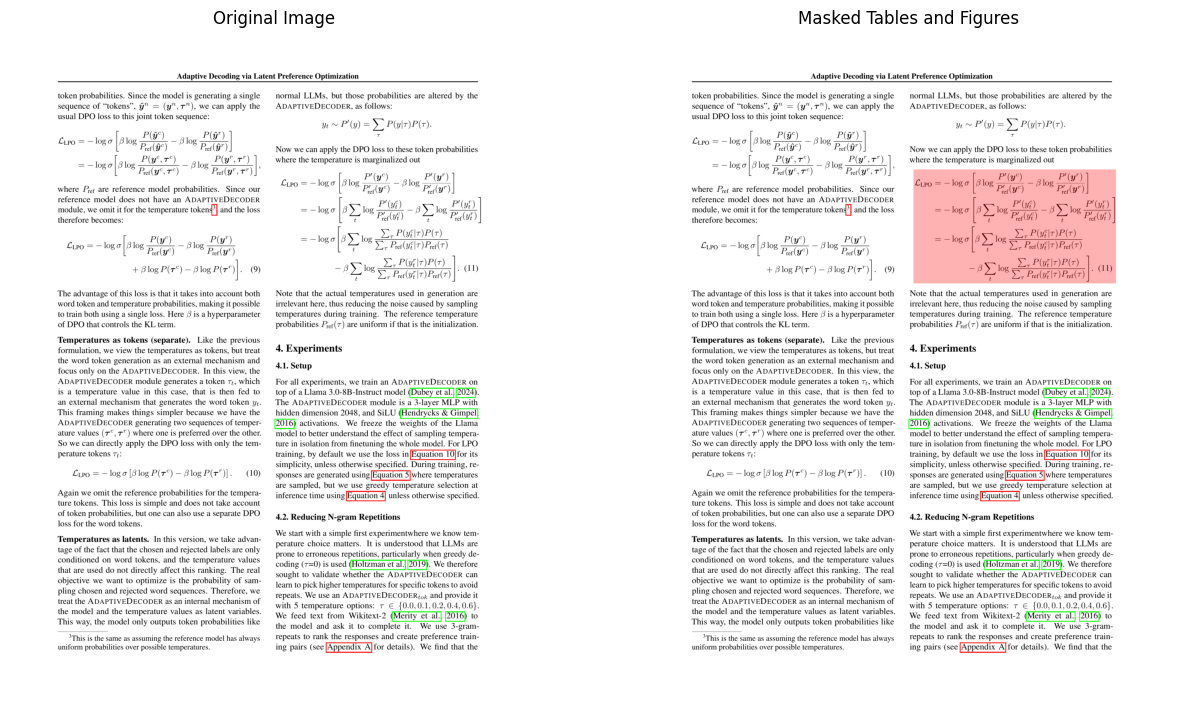

Found 0 tables and 1 figures
Processing page 6/16

Processing page 6
Detecting tables and figures...


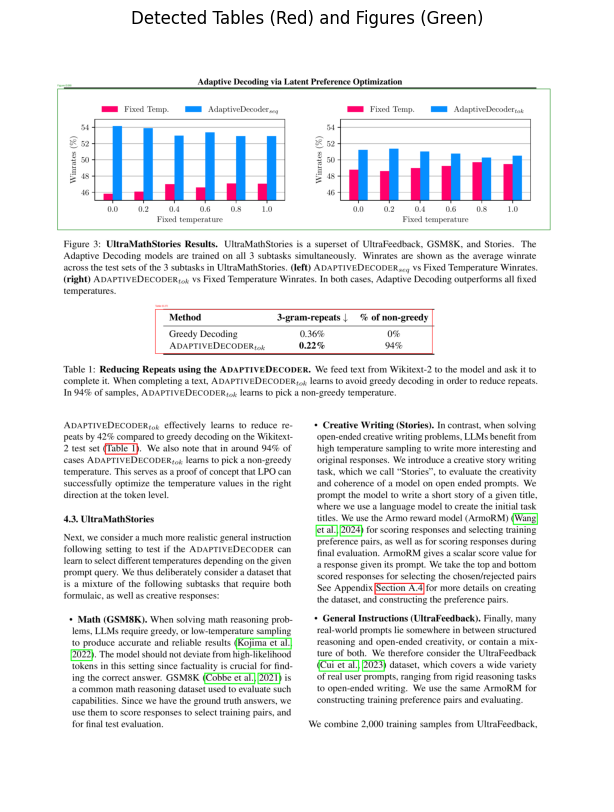

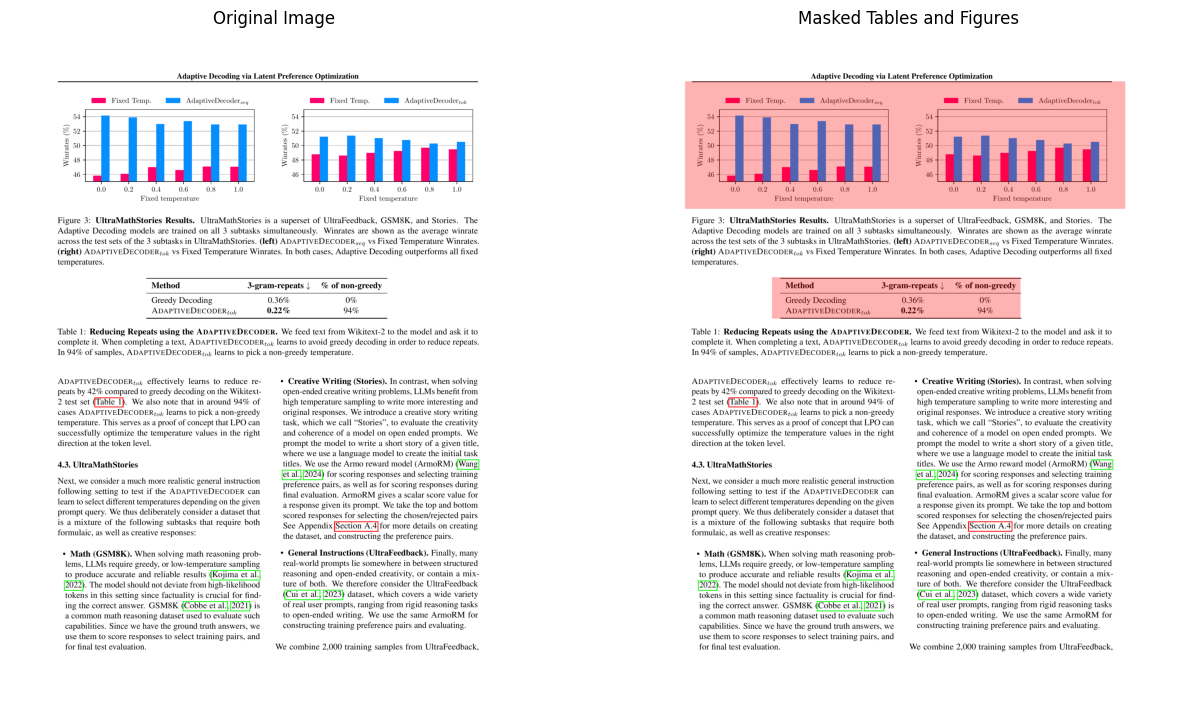

Found 1 tables and 1 figures
Processing page 7/16

Processing page 7
Detecting tables and figures...


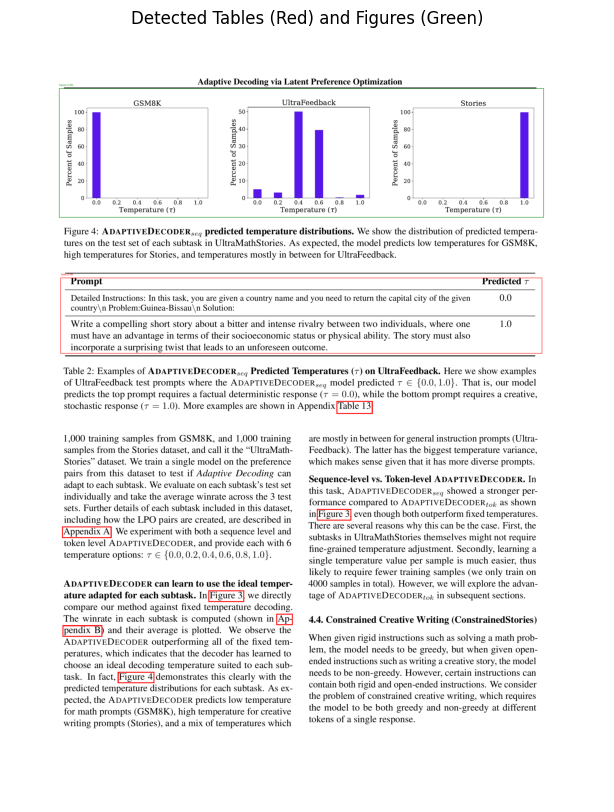

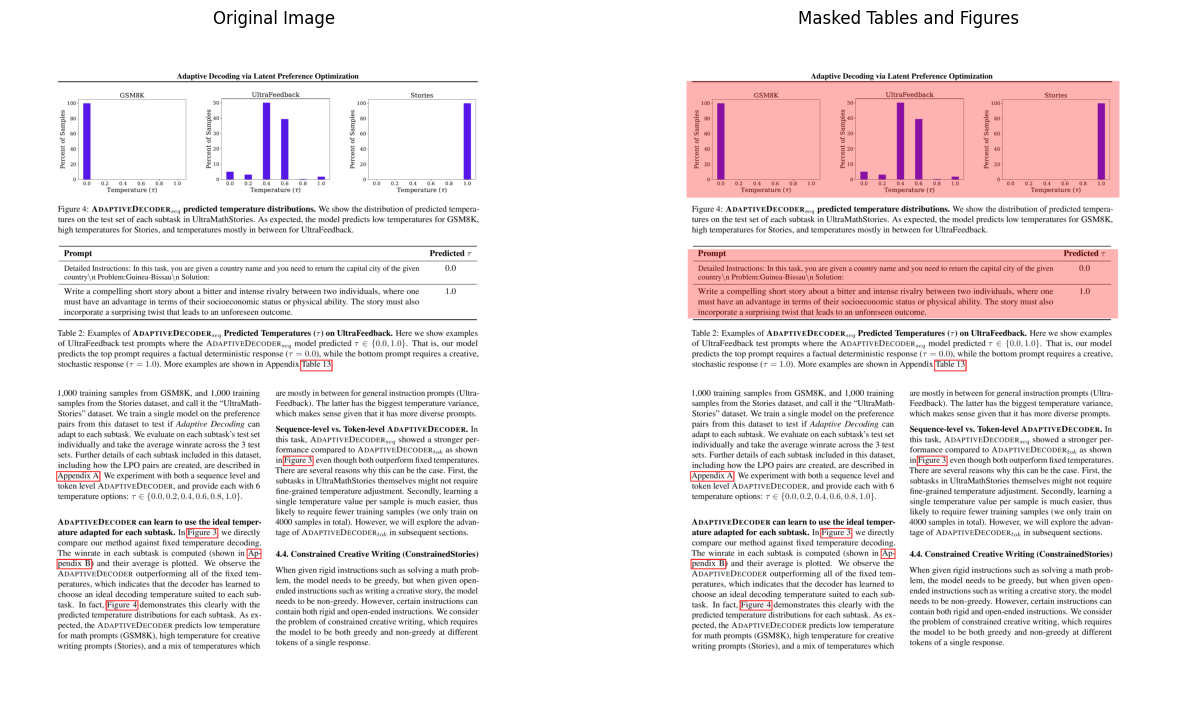

Found 1 tables and 1 figures
Processing page 8/16

Processing page 8
Detecting tables and figures...


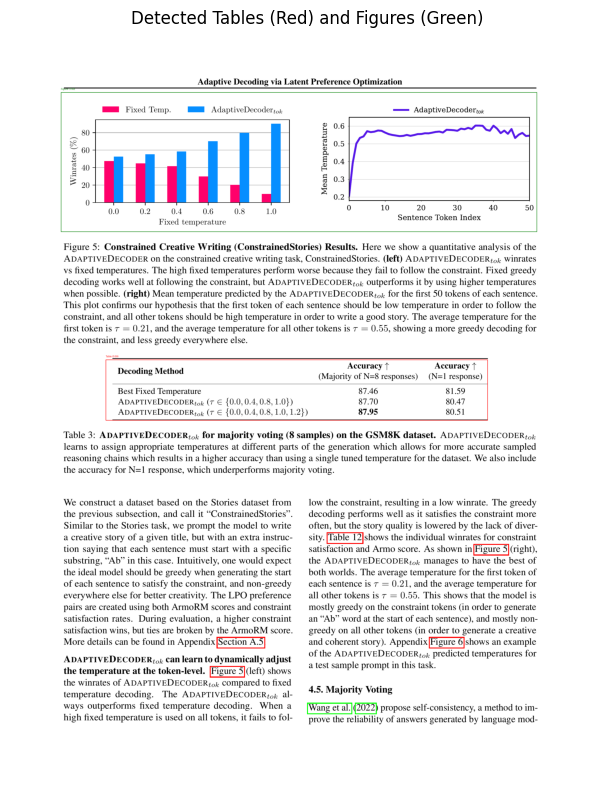

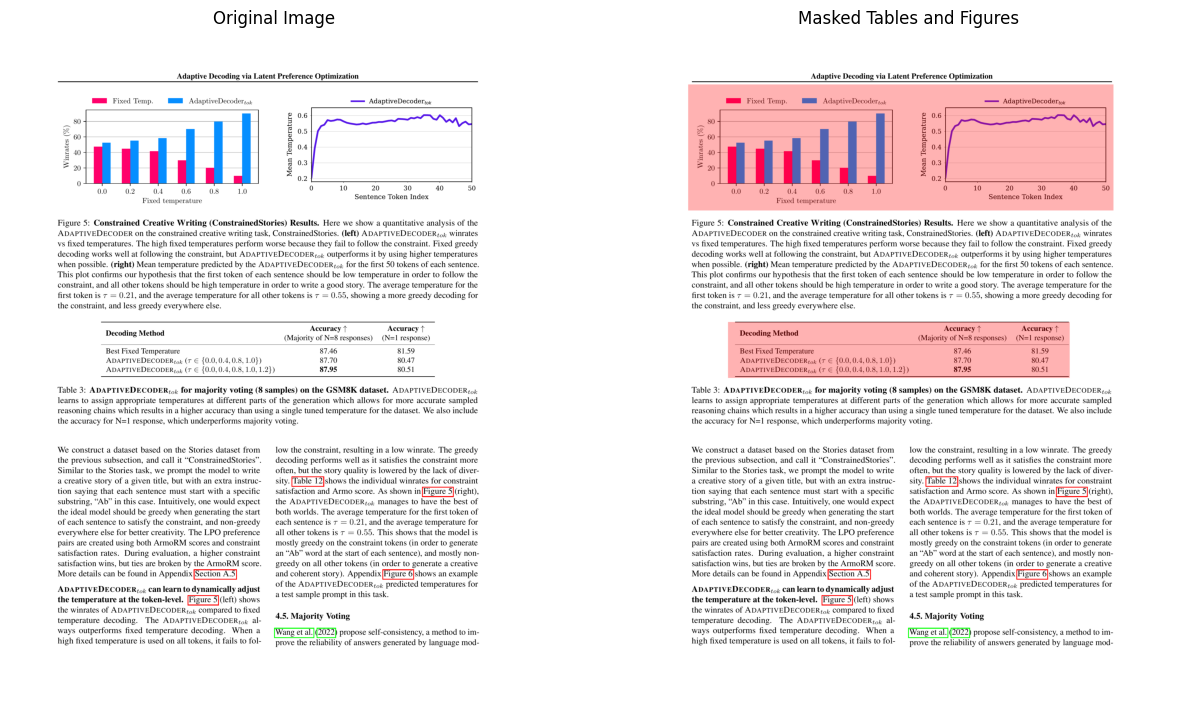

Found 1 tables and 1 figures
Processing page 9/16

Processing page 9
Detecting tables and figures...


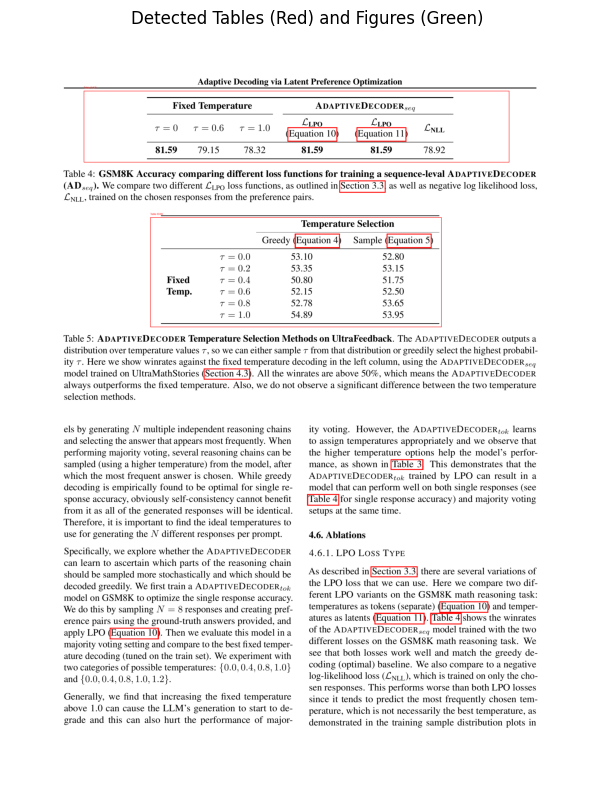

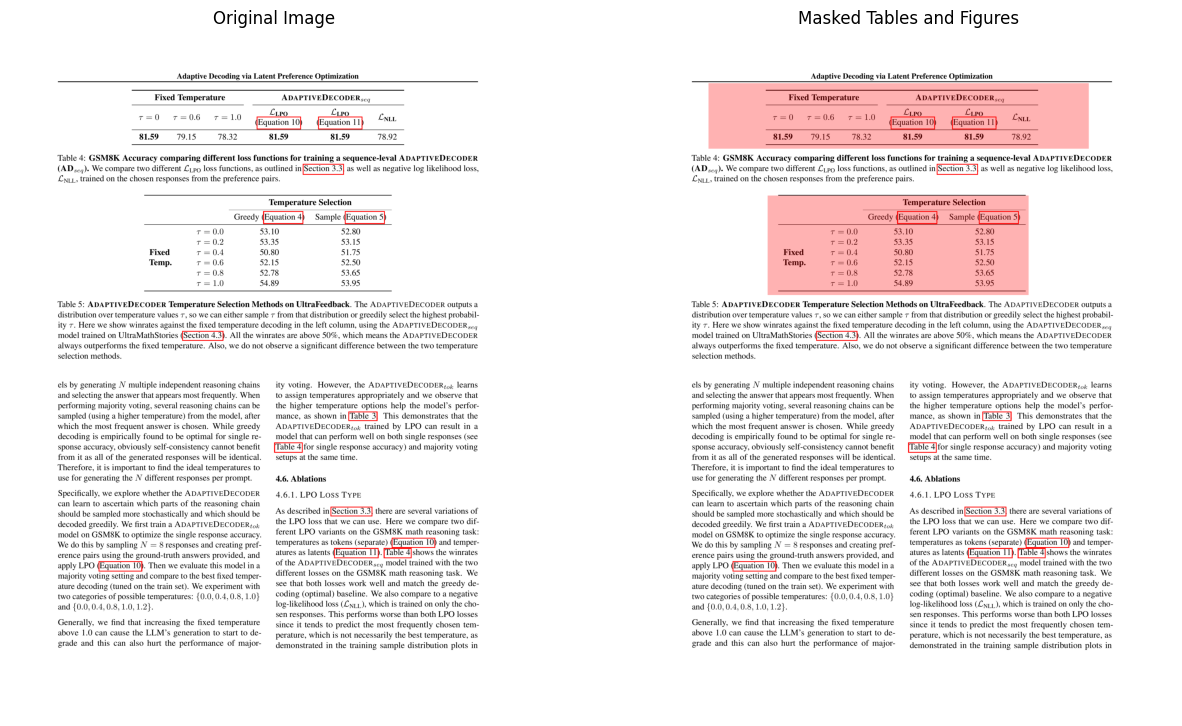

Found 2 tables and 0 figures
Processing page 10/16

Processing page 10
Detecting tables and figures...
No tables or figures found on this page
Processing page 11/16

Processing page 11
Detecting tables and figures...
No tables or figures found on this page
Processing page 12/16

Processing page 12
Detecting tables and figures...
No tables or figures found on this page
Processing page 13/16

Processing page 13
Detecting tables and figures...


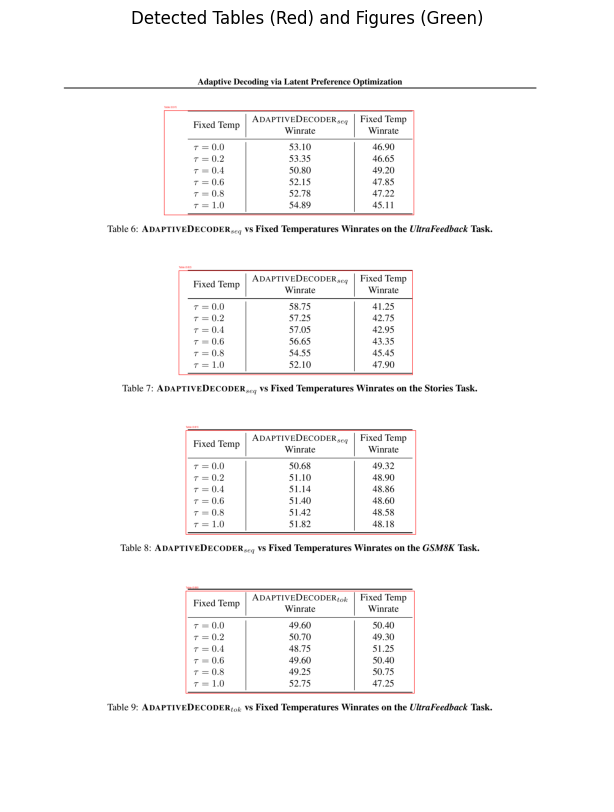

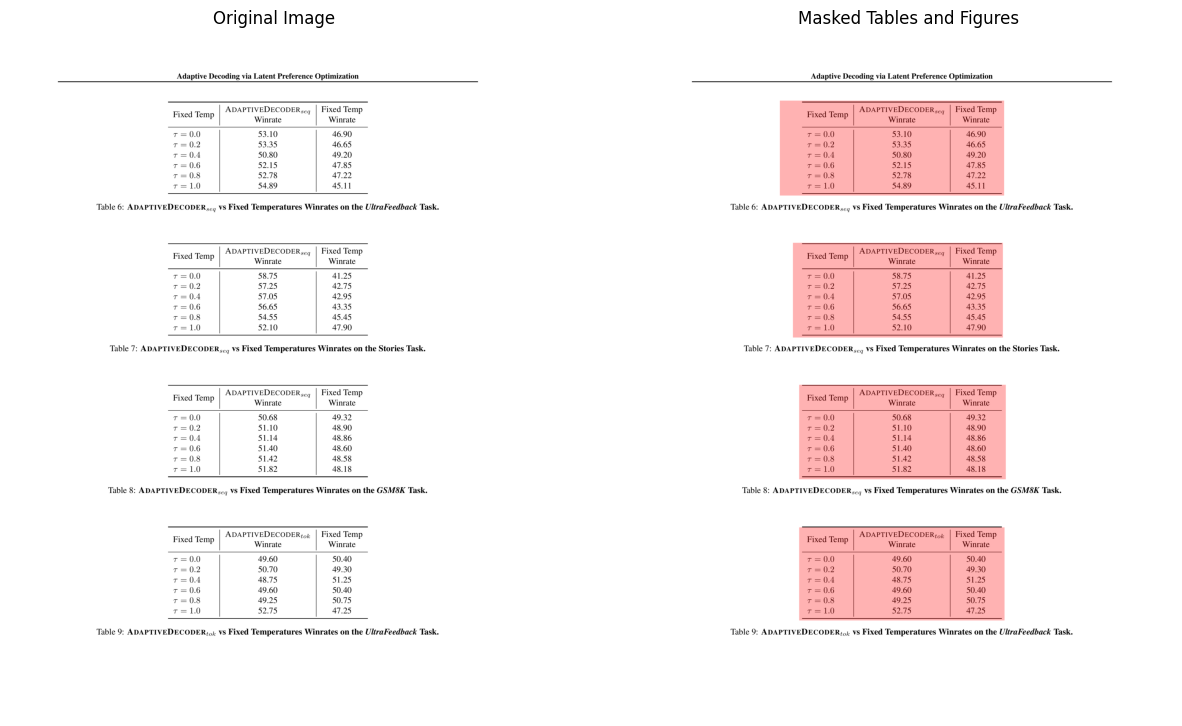

Found 4 tables and 0 figures
Processing page 14/16

Processing page 14
Detecting tables and figures...


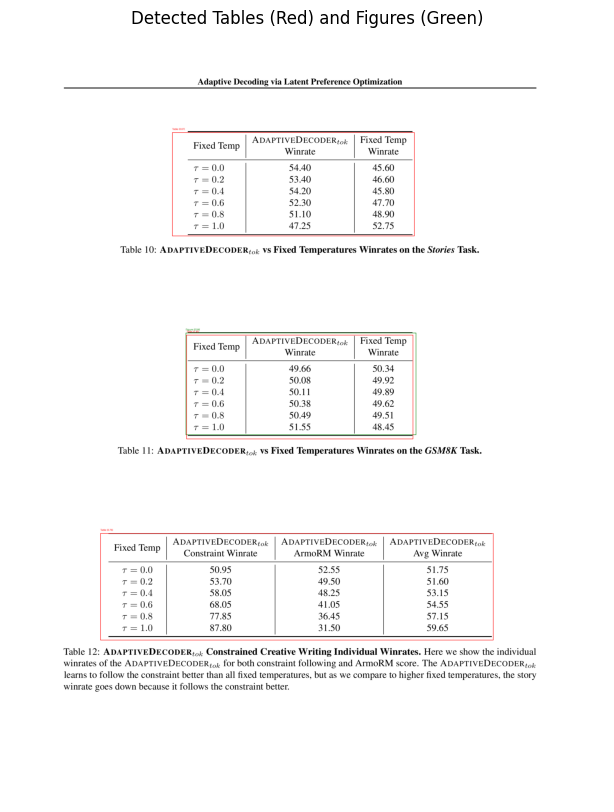

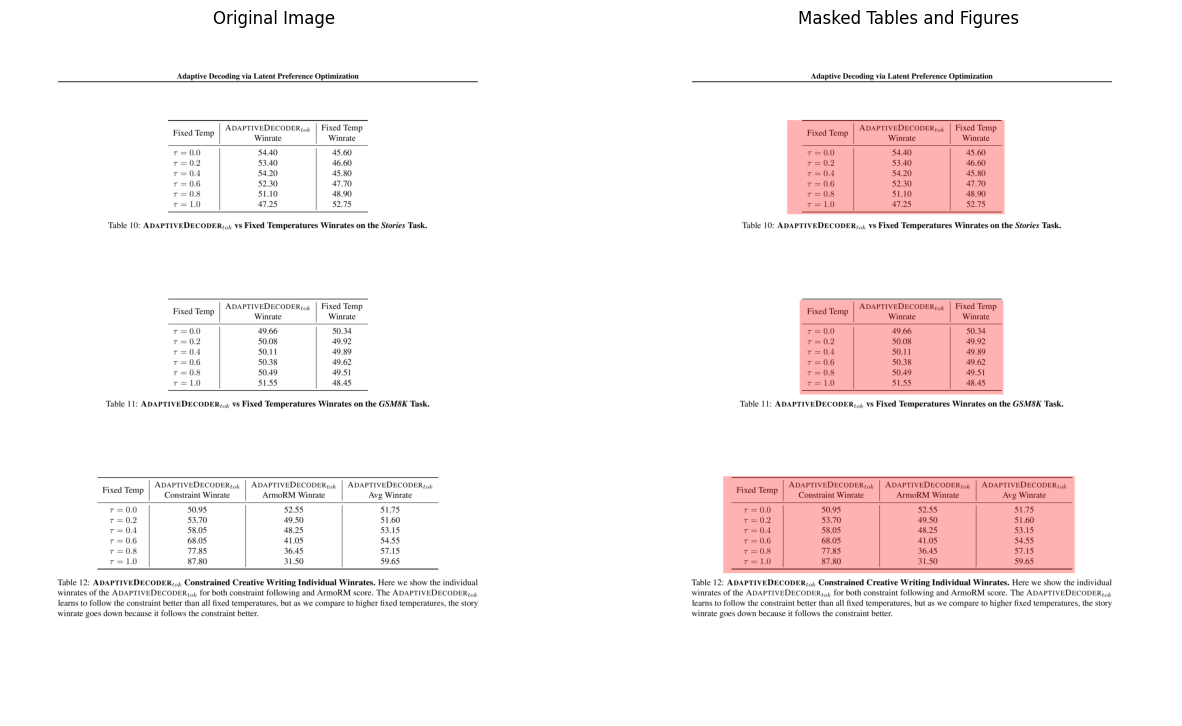

Found 3 tables and 0 figures
Processing page 15/16

Processing page 15
Detecting tables and figures...


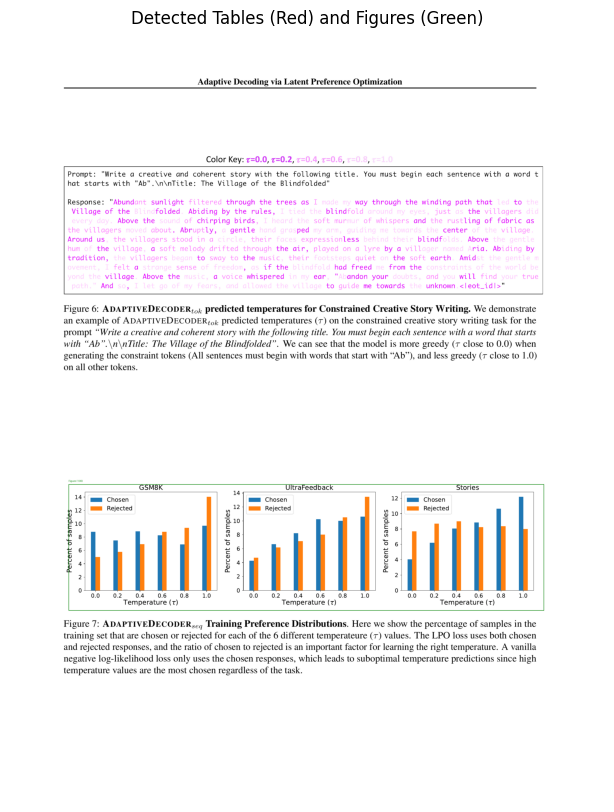

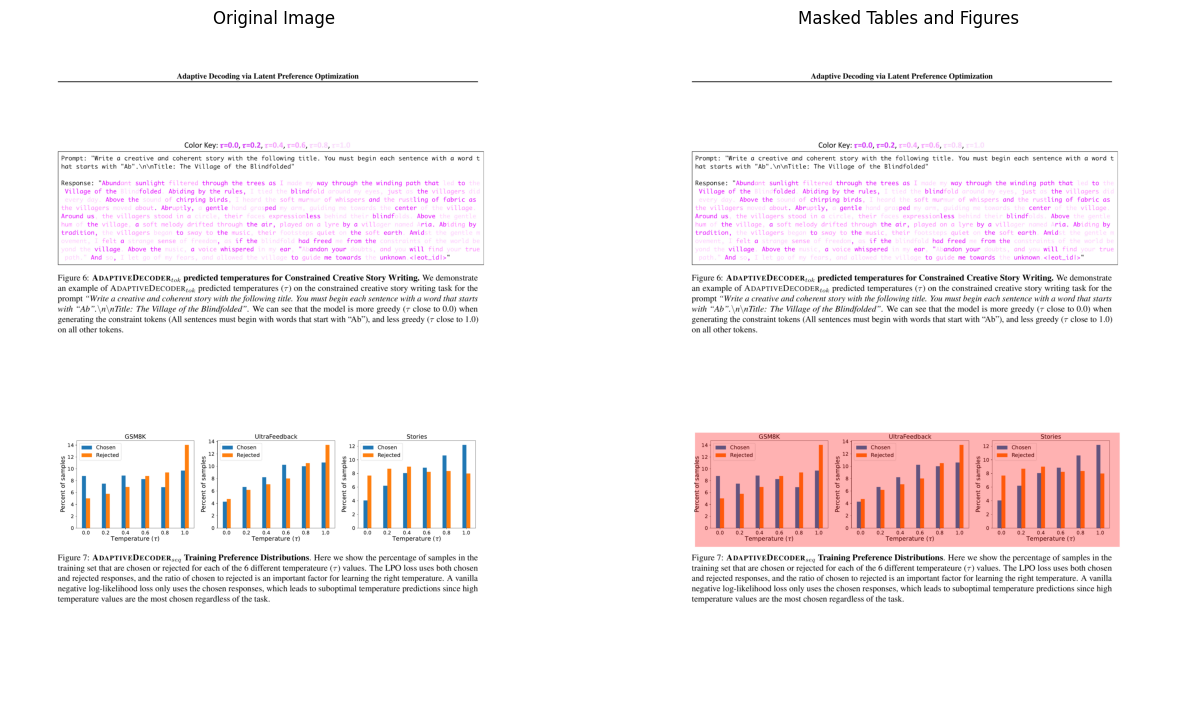

Found 0 tables and 1 figures
Processing page 16/16

Processing page 16
Detecting tables and figures...
No tables or figures found on this page


In [14]:
article_path = Path(r"C:\Users\thinkpad\Documents\GitHub\Textra_ai_research_vc\data\2411.09661v1")
result = process_article(article_path)